# Modular arithmetic

This notebook documents the modular arithmetic bloqs needed to implement the "reference" implementation in [GE2019].

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `ModExp`
Perform $b^e \mod{m}$ for constant `base` $b$, `mod` $m$, and quantum `exponent` $e$.

Modular exponentiation is the main computational primitive for quantum factoring algorithms.
We follow [GE2019]'s "reference implementation" for factoring. See `ModExp.make_for_shor`
to set the class attributes for a factoring run.

This bloq decomposes into controlled modular exponentiation for each exponent bit.

#### Parameters
 - `base`: The integer base of the exponentiation
 - `mod`: The integer modulus
 - `exp_bitsize`: The size of the `exponent` thru-register
 - `x_bitsize`: The size of the `x` right-register 

#### Registers
 - `exponent`: The exponent
 - `x [right]`: The output register containing the result of the exponentiation 

#### References
[GE2019] How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits.
[arxiv:1905.09749](https://arxiv.org/abs/1905.09749). Gidney and Ekerå. 2019.


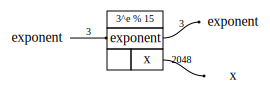

In [2]:
from qualtran.bloqs.factoring.mod_exp import ModExp

bloq = ModExp(base=3, mod=15, exp_bitsize=3, x_bitsize=2048)
show_bloq(bloq)

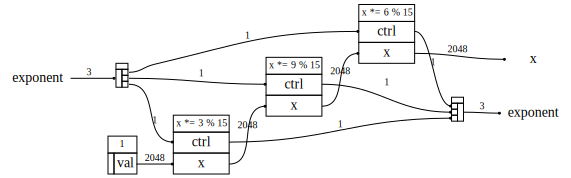

In [3]:
cbloq = bloq.decompose_bloq()
show_bloq(cbloq)

### Larger exponent

The number of `CtrlModMul` scales with the exponent bitsize.

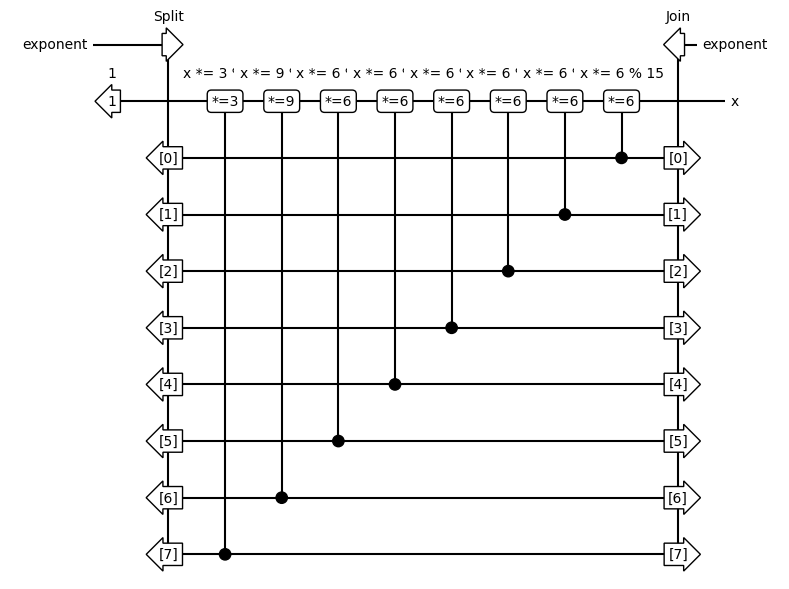

In [4]:
from qualtran.drawing import (
    get_musical_score_data, draw_musical_score, dump_musical_score)

bloq = ModExp(base=3, mod=15, exp_bitsize=8, x_bitsize=2048)
msd_bloq = get_musical_score_data(bloq)
dump_musical_score(msd_bloq, 'mod_exp_bloq')

msd_cbloq = get_musical_score_data(bloq.decompose_bloq())
dump_musical_score(msd_cbloq, 'mod_exp_cbloq')

fig, ax = draw_musical_score(msd_cbloq)
ax.axis('equal')
ax.axis('off')
fig.tight_layout()

In [5]:
# We can quickly count up the number of T-gates required to factor a number
ModExp.make_for_shor(17*19, g=8).t_complexity()

TComplexity(t=30294, clifford=1620, rotations=0)

### Symbolic

`ModExp` supports symbolic parameters. If we use the `make_for_shors` constructor, everything is in terms of the ceil of the base-two logarithm of the composite number.

In [6]:
import sympy
g, N = sympy.symbols('g N')
bloq = ModExp.make_for_shor(big_n=N, g=g)
for reg in bloq.signature:
    display(reg.name, reg.bitsize)

'exponent'

2*ceiling(log(N)/log(2))

'x'

ceiling(log(N)/log(2))

To avoid clutter, we'll use more specific sympy symbols

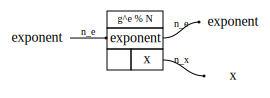

In [7]:
g, N, n_e, n_x = sympy.symbols('g N n_e, n_x')
bloq = ModExp(base=g, mod=N, exp_bitsize=n_e, x_bitsize=n_x)
show_bloq(bloq)

In [8]:
b, x = bloq.call_classically(exponent=sympy.Symbol('b'))
x

Mod(g**b, N)

### Bloq counts

We can see how the modular arithmetic functions decompose into other bloqs until we get to something that can be expressed with T gates.

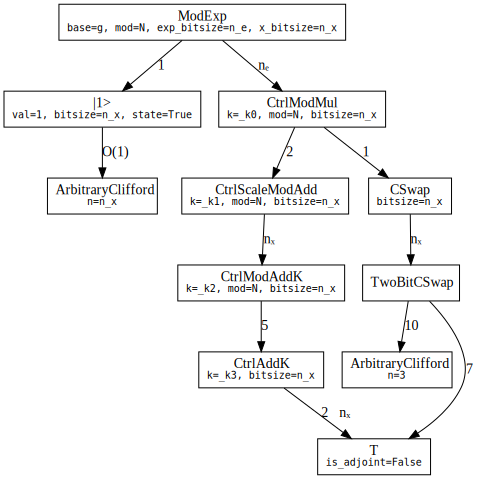

#### Counts totals:
 - `ArbitraryClifford(n=3)`: $\displaystyle 10 n_{e} n_{x}$
 - `ArbitraryClifford(n=n_x)`: $\displaystyle O\left(1\right)$
 - `TGate()`: $\displaystyle n_{e} \left(20 n_{x}^{2} + 7 n_{x}\right)$

In [9]:
from qualtran.drawing import show_call_graph, show_counts_sigma

g, sigma = bloq.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)

## `CtrlModMul`
Perform controlled `x *= k mod m` for constant k, m and variable x.

#### Parameters
 - `k`: The integer multiplicative constant.
 - `mod`: The integer modulus.
 - `bitsize`: The size of the `x` register. 

#### Registers
 - `ctrl`: The control bit
 - `x`: The integer being multiplied


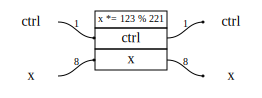

In [10]:
from qualtran.bloqs.factoring.mod_mul import CtrlModMul

bloq = CtrlModMul(k=123, mod=13 * 17, bitsize=8)
show_bloq(bloq)

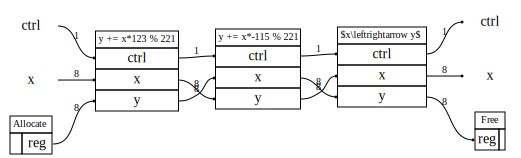

In [11]:
show_bloq(bloq.decompose_bloq())